In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import utils
import importlib
importlib.reload(utils)
from utils import *
import re, string, collections, pickle, os # bcolz
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB, MultinomialNB

import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [5]:
df = pd.read_csv('reviews.csv', lineterminator='\n')
df.shape
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId\r
0,gp:AOqpTOGt2KEhc-yNMmOBsXqfHKLGJ-vDENQPVPlGZIM...,Earl Clark,https://lh3.googleusercontent.com/a-/AOh14Gj_X...,"This is an expensive app. That being said, it'...",1,28,5.0.0.11,2020-05-16 17:23:38,We are not aware of any issues with editing ta...,2020-05-17 12:06:29,most_relevant,com.anydo\r
1,gp:AOqpTOFnIu5LAl0bREEIRnyqUs95zFeDP4kQ-eY638E...,Elad Posner,https://lh3.googleusercontent.com/a-/AOh14Ghzk...,Something is wrong with the last version. Sinc...,1,80,5.0.0.11,2020-05-08 13:48:18,Sorry about that. Please uninstall and reinsta...,2020-05-10 11:25:36,most_relevant,com.anydo\r
2,gp:AOqpTOE4go3obyJs27PrDvsA_mPKmlYD_muUNj3NHNA...,Checaii Garcia,https://lh3.googleusercontent.com/a-/AOh14GiQ8...,I wanted to try the app but it never opens. I ...,1,23,5.0.0.11,2020-05-08 10:26:34,Sorry about that! Please feel free to contact ...,2020-05-10 11:20:14,most_relevant,com.anydo\r
3,gp:AOqpTOF3Kb-6IdEeeYLcuUncmzjQdtNguLU5GTshqNY...,A Traveller,https://lh3.googleusercontent.com/-yutN8c-KH6U...,This app is a prime example of building a moun...,1,14,5.0.0.11,2020-05-09 19:20:56,If you're having trouble figuring out how to t...,2020-05-12 10:22:05,most_relevant,com.anydo\r
4,gp:AOqpTOEcQLSS_guCIsZflL1BJmk6h6WHCVNSFO_OI1N...,Kenneth Ho,https://lh3.googleusercontent.com/a-/AOh14GitU...,I have been using it since 2018 and am current...,1,12,5.0.0.11,2020-05-08 21:56:31,"Hi, please note that we detected a slight issu...",2020-05-10 11:57:17,most_relevant,com.anydo\r


In [6]:
# We just keep 2 columns: text and score
df = df[['content', 'score']]
df.head()

,content,score
0,"This is an expensive app. That being said, it'...",1
1,Something is wrong with the last version. Sinc...,1
2,I wanted to try the app but it never opens. I ...,1
3,This app is a prime example of building a moun...,1
4,I have been using it since 2018 and am current...,1


In [9]:
pos = df.loc[df['score'] > 4, 'content'].copy().reset_index(drop=True)
neg = df.loc[df['score'] < 2, 'content'].copy().reset_index(drop=True)
print(len(pos), len(neg))

2908 2594


In [10]:
# Positive examples
print(''.join(pos[np.random.randint(0, len(pos))]))

I really like this app. The only things I would request is a full month breakdown of each task/habit that was recorded/ accomplished and it's stats. Also if a goals option could be added in addition to task and habit


In [11]:
# Negative examples
print(''.join(neg[np.random.randint(0, len(neg))]))

The app itself is great. I used it quite regularly a few years back but when I tried to use it again it seems that the 'new' owners don't acknowledge their 'lifetime' subscription. Sure hope my emails get more results besides ... /ignore kthnxbye Sent an email ... they said they opened a ticket and then ... crickets. Nice .. thanks, downgraded to


In [12]:
neg = pd.concat([pd.DataFrame(neg), pd.DataFrame(np.zeros(neg.shape), columns=['class'])], 1)
pos = pd.concat([pd.DataFrame(pos), pd.DataFrame(np.ones(pos.shape), columns=['class'])], 1)

186.2000771010023 150.042628163116 1852


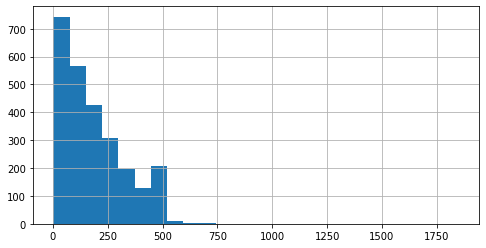

In [14]:
# Mean, standard deviation and max length (no. of characters)
# Negative reviews
lens = neg['content'].str.len()
print(lens.mean(), lens.std(), lens.max())
lens.hist(figsize=(8, 4), bins=25)

151.66403026134802 144.44700519257646 1282


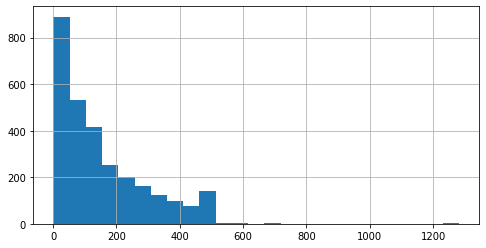

In [15]:
# Positive reviews
lens = pos['content'].str.len()
print(lens.mean(), lens.std(), lens.max())
lens.hist(figsize=(8, 4), bins=25)

In [17]:
# Reviews with more than 5000 characters are dropped
# Negative reviews
long_reviews = neg.loc[neg['content'].str.len() > 5000].index
neg.drop(long_reviews, inplace=True)
# Positive reviews
long_reviews = pos.loc[pos['content'].str.len() > 5000].index
pos.drop(long_reviews, inplace=True)

In [18]:
np.random.seed(42)
rand = np.random.permutation(pos.shape[0])
pos = pos.iloc[rand[:neg.shape[0]]].reset_index(drop=True)
print(neg.shape, pos.shape)

(2594, 2) (2594, 2)


In [19]:
#!# We educe the dataset further so that it computes faster
#1# Better models may require the full dataset
np.random.seed(42)
rand = np.random.permutation(pos.shape[0])
pos = pos.iloc[rand[:10000]].reset_index(drop=True)
rand = np.random.permutation(neg.shape[0])
neg = neg.iloc[rand[:10000]].reset_index(drop=True)

In [20]:
# We merge the positive and negative reviews, and suffle the rows
df = pd.concat([pos, neg]).sample(frac=1, random_state=42).reset_index(drop=True)
print(df.shape)
df.head()

(5188, 2)


,content,class
0,Couldn't figure out how to set reminder times ...,0.0
1,"I couldn't register , the circle rounds and ro...",0.0
2,I received a notice from planner pro this morn...,0.0
3,"Since Microsoft scrapped ""Wunderlist"" for ""Mic...",1.0
4,Thanks for pop-up windows returned,1.0


In [22]:
# Replacing carriage returns \r
df['content'] = df['content'].str.replace('\r',' ')

In [23]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

for i in range(df.shape[0]):
    clean_tokens = ''
    for w in word_tokenize(df.loc[:, ('content')][i]):
        if w not in stop_words:
            clean_tokens = clean_tokens + ' ' + lemmatizer.lemmatize(w)
    df['content'][i] = clean_tokens.translate(str.maketrans('', '', string.punctuation))

C:\Users\zoe_k\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [24]:
df.head()

,content,class
0,Could nt figure set reminder time wo nt anything,0.0
1,I could nt register circle round round And ...,0.0
2,I received notice planner pro morning I went ...,0.0
3,Since Microsoft scrapped Wunderlist Micros...,1.0
4,Thanks popup window returned,1.0


In [26]:
print(nltk.pos_tag(word_tokenize(df['content'][1])))

[('I', 'PRP'), ('could', 'MD'), ('nt', 'VB'), ('register', 'JJ'), ('circle', 'NN'), ('round', 'NN'), ('round', 'NN'), ('And', 'CC'), ('nothing', 'NN'), ('happens', 'NNS')]


In [27]:
# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
from nltk.corpus import wordnet
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [30]:
for i in range(3):
    print(df['content'][i])
    print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(df['content'][i])])
    print('\n')

 Could nt figure set reminder time wo nt anything
['Could', 'nt', 'figure', 'set', 'reminder', 'time', 'wo', 'nt', 'anything']


 I could nt register  circle round round  And nothing happens
['I', 'could', 'nt', 'register', 'circle', 'round', 'round', 'And', 'nothing', 'happens']


 I received notice planner pro morning I went schedule appts  notifies I use app payment received  iI checked bank payment made 01262019  I cancelling unable use 
['I', 'receive', 'notice', 'planner', 'pro', 'morning', 'I', 'go', 'schedule', 'appts', 'notifies', 'I', 'use', 'app', 'payment', 'receive', 'iI', 'checked', 'bank', 'payment', 'make', '01262019', 'I', 'cancel', 'unable', 'use']




In [31]:
def get_clean_token(txt):
    return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(txt)]

vect = CountVectorizer(tokenizer=get_clean_token)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df['content'].values, df['class'].values, test_size=0.2, random_state=42)
tf_train = vect.fit_transform(X_train)
tf_test = vect.transform(X_test)

In [33]:
print(tf_train[0])

  (0, 1428)	1
  (0, 3008)	1
  (0, 4803)	1
  (0, 4740)	1
  (0, 4375)	1
  (0, 4416)	1
  (0, 4479)	1
  (0, 617)	1
  (0, 3785)	1
  (0, 1911)	1
  (0, 3076)	1
  (0, 1339)	1
  (0, 2947)	1
  (0, 619)	1


In [34]:
tf_train

<4150x5329 sparse matrix of type '<class 'numpy.int64'>'
	with 69298 stored elements in Compressed Sparse Row format>

In [35]:
vocab = vect.get_feature_names()
len(vocab)

5329

In [36]:
model = MultinomialNB().fit(tf_train.toarray(), y_train)
prediction = model.predict(tf_test.toarray())
acc = (prediction==y_test).mean()
print(f'Accuracy: {acc}')

Accuracy: 0.918111753371869


In [37]:
cm = confusion_matrix(y_test, prediction.T)
print(cm)
plot_confusion_matrix(cm, classes=['Negative', 'Positive'])

[[476  41]
 [ 44 477]]


NameError: name 'plot_confusion_matrix' is not defined